In [14]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from utils import *

DATA_PATH = '../data/esp/'

%load_ext autoreload
%autoreload 2

In [15]:
df = load_data(DATA_PATH,'train',nclasses=5).loc[:,['review_content','review_rate']]
df.head(5)

Dataset cargado para 5 clases (muy malo=0, malo=2, medio=3, bueno=4 muy bueno=1)
Num samples per category:
1    92375
2    92375
3    92375
4    92375
5    92375
Name: review_rate, dtype: int64


,review_content,review_rate
0,"Medio berreta, no justifica el gasto, ya se sa...",1
1,Quizás a unas personas les sirve y a otras no ...,3
2,Excelente !! superó mi expectativas. Lo único ...,5
3,Es una buena relación calidad/precio. La cámar...,4
4,"Muy poca voluntad para ayudarme con cambiarlo,...",1


## Inspeccionamos los caracteres presentes en el texto

In [27]:
from collections import Counter

characters_counts = Counter(''.join(df['review_content'].tolist()))
counts = np.array(list(characters_counts.values()))
idx_sorted = np.argsort(counts)[::-1]
counts = counts[idx_sorted]
chars = np.array(list(characters_counts.keys()))[idx_sorted]

<IPython.core.display.Javascript object>


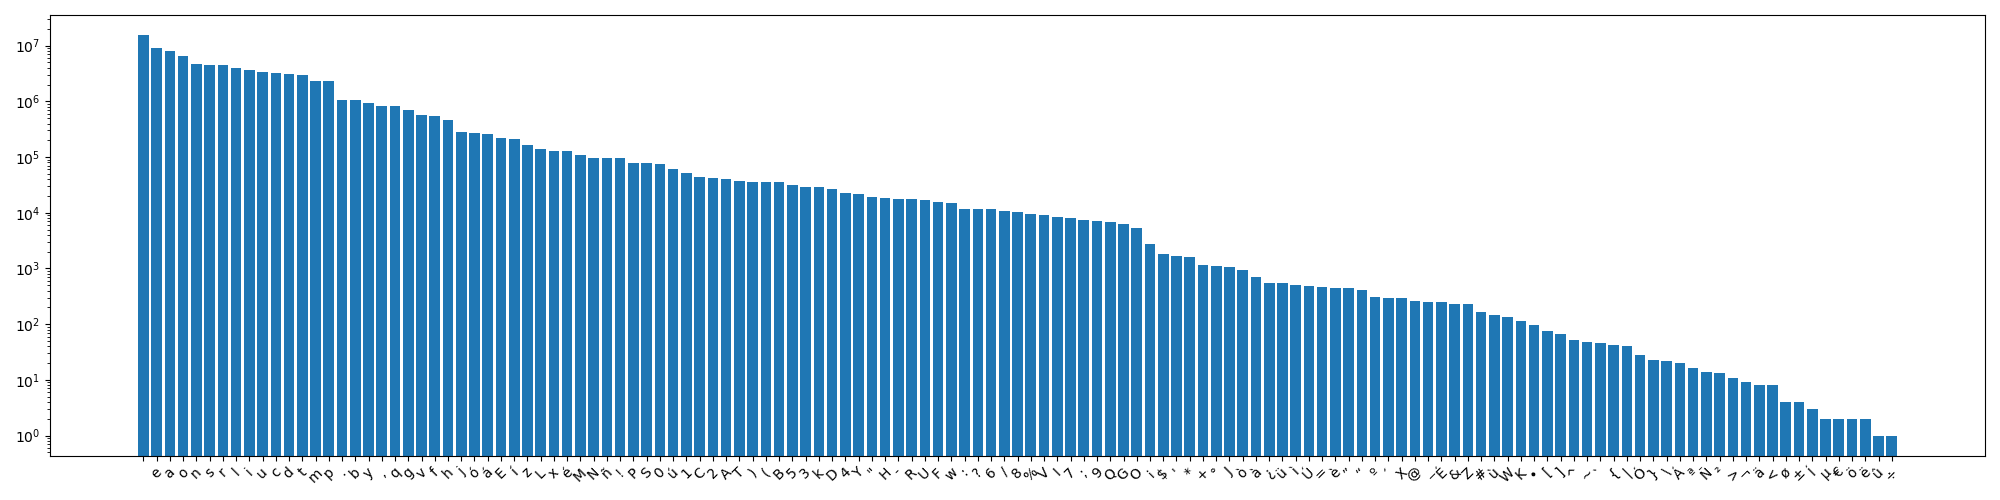

In [32]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
ticks = np.arange(len(counts))
ax.bar(ticks, counts)
ax.set_xticks(ticks)
ax.set_xticklabels(chars,fontsize='medium',rotation=45)
ax.set_yscale('log')
fig.tight_layout()

In [33]:
chars

array([' ', 'e', 'a', 'o', 'n', 's', 'r', 'l', 'i', 'u', 'c', 'd', 't',
       'm', 'p', '.', 'b', 'y', ',', 'q', 'g', 'v', 'f', 'h', 'j', 'ó',
       'á', 'E', 'í', 'z', 'L', 'x', 'é', 'M', 'N', 'ñ', '!', 'P', 'S',
       '0', 'ú', '1', 'C', '2', 'A', 'T', ')', '(', 'B', '5', '3', 'k',
       'D', '4', 'Y', '"', 'H', '-', 'R', 'U', 'F', 'w', ':', '?', '6',
       '/', '8', '%', 'V', 'I', '7', ';', '9', 'Q', 'G', 'O', '¡', '$',
       "'", '*', '+', '°', 'J', 'ò', 'à', '¿', 'ü', 'ì', 'Ú', '=', 'è',
       '”', '“', 'º', '´', 'X', '@', '_', 'É', '&', 'Z', '#', 'ù', 'W',
       'K', '•', '[', ']', '^', '~', '`', '{', '|', 'Ó', '}', '\\', 'Á',
       'ª', 'Ñ', '²', '>', '¬', 'ä', '<', 'ø', '±', 'Í', 'µ', '€', 'ö',
       'ë', 'û', '÷'], dtype='<U1')

In [48]:
from scipy.sparse import csr_matrix

Xs = csr_matrix(np.array([[10, 10, 10, 10],
                          [10, 10, 10,  0],
                          [10, 10,  0,  0],
                          [ 0,  0,  0,  1]],dtype=float).T)

def sparse_matrix_by_column(X,column,op):
    X = X.copy()
    X.data = op(X.data,np.repeat(column,np.diff(X.indptr)))
    return X

def sparse_matrix_by_row(X,row,op):
    X = X.copy()
    X.data = op(X.data,row[X.indices])
    return X

def sparse_matrix_log(X):
    X = X.copy()
    X.data = np.log(X.data,where=X.data != 0.) # log(0) = 0
    return X 

def tfidf(X):
    """
    Convierte una matriz sparse de dimension (n_docs x n_words) en la matriz tfidf
    """
    idf = np.log(X.shape[0] / np.asarray(X.astype(bool).sum(axis=0)).squeeze())
    tf = sparse_matrix_by_column(X,np.asarray(X.sum(axis=1)).squeeze(),op=np.divide)
    X_tfidf = sparse_matrix_by_row(tf,idf,op=np.multiply)
    return X_tfidf

def ppmi(X):
    """
    Convierte una matriz sparse de dimension (n_docs x n_words) en la matriz ppmi
    """
    sum_all = X.sum()
    prob_col = np.asarray(X.sum(axis=1)).squeeze() / sum_all
    prob_row = np.asarray(X.sum(axis=0)).squeeze() / sum_all
    prob_all = X / sum_all
    prob_all = sparse_matrix_by_row(prob_all,prob_row,op=np.divide)
    prob_all = sparse_matrix_by_column(prob_all,prob_col,op=np.divide)
    prob_all = sparse_matrix_log(prob_all).maximum(0)
    return prob_all

Xtfidf = tfidf(Xs)
Xtfidf.toarray()

Xppmi = ppmi(Xs)
Xppmi.toarray()

array([[0.        , 0.01104984, 0.41651494, 0.        ],
       [0.        , 0.01104984, 0.41651494, 0.        ],
       [0.12883287, 0.41651494, 0.        , 0.        ],
       [0.72666987, 0.        , 0.        , 2.11296423]])

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def sparse_matrix_by_column(X,column,op):
    X = X.copy()
    X.data = op(X.data,np.repeat(column,np.diff(X.indptr)))
    return X

def sparse_matrix_by_row(X,row,op):
    X = X.copy()
    X.data = op(X.data,row[X.indices])
    return X

def sparse_matrix_log(X):
    X = X.copy()
    X.data = np.log(X.data,where=X.data != 0.) # log(0) = 0
    return X 

class BowNbClassifier(object):
    
    def __init__(self,tokenizer,max_ngrams,ngram_range,reweight=None):
        self.vec = CountVectorizer(input='content',encoding='utf-8',decode_error='strict',strip_accents=None,
              lowercase=False,preprocessor=None,tokenizer=tokenizer,stop_words=None,token_pattern=None,
              ngram_range=ngram_range,analyzer='word',max_df=1.,min_df=1,max_features=max_ngrams,
              vocabulary=None,binary=False,dtype=float)
        self.clf = MultinomialNB()
        self.reweight = reweight
        
    def reweight_matrix(self,X):
        if self.reweight is None:
            pass
        elif self.reweight == 'tfidf':
            idf = np.log(X.shape[0] / np.asarray(X.astype(bool).sum(axis=0)).squeeze())
            tf = sparse_matrix_by_column(X,np.asarray(X.sum(axis=1)).squeeze(),op=np.divide)
            X = sparse_matrix_by_row(tf,idf,op=np.multiply)
        elif self.reweight == 'ppmi':
            sum_all = X.sum()
            prob_col = np.asarray(X.sum(axis=1)).squeeze() / sum_all
            prob_row = np.asarray(X.sum(axis=0)).squeeze() / sum_all
            prob_all = X / sum_all
            prob_all = sparse_matrix_by_row(prob_all,prob_row,op=np.divide)
            prob_all = sparse_matrix_by_column(prob_all,prob_col,op=np.divide)
            X = sparse_matrix_log(prob_all).maximum(0)
        else:
            raise TypeError('reweight must be "ppmi", "tfidf" or None.')
        return X
        
    def train(self,ds,y):
        X = self.vec.fit_transform(ds)
        X = self.reweight_matrix(X)
        self.clf.fit(X,y)
        
    def predict(self,ds):
        X = self.vec.transform(ds)
        X = self.reweight_matrix(X)
        y_pred = self.clf.predict(X)
        return y_pred
    

token_pattern = re.compile(r'(\w+|[\.,!\(\)"\-:\?/%;¡\$\'¿\\]|\d+)')

clf = BowNbClassifier(tokenizer=lambda sent: token_pattern.findall(sent),
                      max_ngrams=10000,ngram_range=(1,1),reweight=None)

ds, y = df['review_content'], df['review_rate'].values
clf.train(ds,y)
y_pred = clf.predict(df['review_content'][:100])
print('Accuracy: {:.2f}%'.format(sum(y_pred == df['review_rate'][:100].values) / len(y_pred) * 100 ))

Accuracy: 55.00%


In [4]:
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
import re

token_pattern = re.compile(r'(\w+|[\.,!\(\)"\-:\?/%;¡\$\'¿\\]|\d+)')
tknzr = TweetTokenizer(strip_handles=True,reduce_len=True)

tokenizers = [
    lambda sent: word_tokenize(sent,'spanish'),
    lambda sent: token_pattern.findall(sent),
    lambda sent: tknzr(sent)
]



In [21]:
from collections import Counter
from itertools import chain
import re

class RegexTokenizer(object):
    # TODO: ADAPTARLO A N-GRAMAS
    def __init__(self,token_pattern):
        self.token_pattern = re.compile(token_pattern)
      
    def tokenize(self,sent):
        return self.token_pattern.findall(sent)
    
    def train(self,corpus,max_words,freq_cutoff):
        word_freq = Counter(chain(*[self.tokenize(sent) for sent in corpus]))
        valid_words = [w for w, v in word_freq.items() if v >= freq_cutoff]
        top_k_words = sorted(valid_words, key=lambda w: word_freq[w], reverse=True)[:max_words]
        self.vocab = {word: idx for idx, word in enumerate(top_k_words)}
        print('Vocab size: {}'.format(len(self.vocab)))
    
    def sentences_to_ids(self,corpus):
        vocab = self.vocab
        ids = [[vocab[tk] for tk in self.tokenize(doc) if tk in vocab] for doc in corpus]
        return ids
    
tokenizer = RegexTokenizer(token_pattern=r'(\w+|[\.,!\(\)"\-:\?/%;¡\$\'¿\\]|\d+)')
tokenizer.train(df['review_content'],max_words=10000,freq_cutoff=1)
ids = tokenizer.sentences_to_ids(df['review_content'][100:110])
ids[:3]

Vocab size: 10000


[[77,
  1,
  19,
  194,
  49,
  1,
  8,
  12,
  733,
  0,
  257,
  79,
  9084,
  9,
  25,
  79,
  37,
  694,
  1,
  39,
  79,
  10,
  6,
  1918,
  30,
  486,
  2,
  302,
  52,
  1241,
  16,
  3636,
  0,
  1086,
  8,
  12,
  33,
  4,
  966,
  1,
  39,
  79,
  61,
  8,
  0],
 [29,
  3227,
  2,
  391,
  3,
  41,
  19,
  190,
  1413,
  14,
  50,
  1,
  39,
  3,
  73,
  357,
  681,
  31,
  8,
  516,
  48,
  6,
  1394,
  3,
  536,
  757,
  877,
  13,
  3,
  5160,
  1,
  235,
  2,
  3,
  95,
  11,
  724,
  24,
  470,
  32,
  11,
  3917,
  24,
  470,
  2,
  98,
  3421,
  229,
  2,
  93,
  3,
  8088,
  15,
  3118,
  1,
  64,
  12,
  22,
  0],
 [6,
  184,
  339,
  541,
  1,
  2677,
  172,
  132,
  64,
  1825,
  10,
  5,
  6606,
  0,
  149,
  6,
  1051,
  118,
  12,
  47,
  453,
  13,
  268,
  1280,
  10,
  217,
  5319,
  0,
  7128,
  3,
  704,
  25,
  13,
  104,
  28,
  705,
  2,
  5,
  5373,
  2,
  3740,
  17,
  121,
  6,
  184,
  3794,
  37,
  122,
  2,
  1157,
  10,
  6479,
  2,
  0]]